<a href="https://colab.research.google.com/github/STRMNGnwo/Final-Year-Project/blob/main/Stable_Atrous_Convolutions__FYP_UNETmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting the Google Drive where the dataset is stored, after being processed by the Local stage of the pre-processing pipeline.**


In [ ]:
from google.colab import files
from google.colab import drive

#files.upload()

#g drive file path to total dataset /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/datasets
#g drive file path to split dataset /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Split_Patients
#g drive file path to split dataset /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/
drive.mount("/content/drive/") 


Mounted at /content/drive/


# **Importing the required libraries**

In [ ]:
!pip install torchmetrics
#importing the required modules to create the U-Net model
import torch, torchvision
from torch.nn import Module
from torch.nn import Conv2d #The convolutional layer used in the U-Net architecture
from torch.nn import ReLU #activation function
from torch.nn import BatchNorm1d, BatchNorm2d
from torch.nn import Sequential
from torch.nn import functional as f #to make the fully connected layer
from torch.nn import ConvTranspose2d
from torch.nn import MaxPool2d #max pooling layer that is implemented after Conv2d layers
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tqdm

import os
import sys

sys.path.insert(0, '/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/')

#from CustomDataset import SegmentationCTADataset
from CustomDataset import CTADataset
#from split_patients import remove_DS_Store, split_patients, copy_collate_datasets

if torch.cuda.is_available():
  device=torch.device("cuda")
  torch.cuda.get_device_name(0)
  print("GPU")

else:
  device="cpu"
  print("CPU")



# **Importing the dataset data by unzipping the prepared dataset file in the Google Drive.**

The dataset has been split into train,test and val sets by the Local stage of the data pre-processing pipeline.


In [ ]:

!unzip /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Prepared_Dataset_Seed7.zip

#unzip /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Sample_Prepared_Dataset.zip

#unzip /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/SampleTrain.zip


# **Building the Model**

# **The Block class**

Used by Encoder, Bottleneck and Decoder sections to perform Atrous Convolutions.

In [ ]:
#Building block of both Encoder section and Decoder section.
#At a high level: Encoder= Block +downsampling (max_pooling), Decoder= upsampling+ skip connection concatenation + Block
# Block -> Double Convolutional layers, with Batch Normalisation and ReLU activation functions between them.


#Atrous Convolutions can be implemented at Block level -> mention dilation rate as a parameter in the Conv2d
class Block(Module):

    def __init__(self, in_channels,out_channels,dilation_rate=2):
        
        super().__init__()

        self.conv=Sequential(
            #Conv1
            #in_channels,out_channels,filter_size(kernel),stride,padding(same padding=1), bias
            Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=dilation_rate,dilation=dilation_rate,bias=False), # bias is false because batch normalisation is used in the next step and it cancels out bias
            #NOTE: Would I need BatchNorm1D or BatchNorm2D?
            
            BatchNorm2d(out_channels),
            ReLU(inplace=True),

            #Conv2
            Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=dilation_rate,dilation=dilation_rate,bias=False), #bias=False because batch normalisation is used in the next step and it cancels out bias
            #NOTE: Would I need BatchNorm1D or BatchNorm2D?
            
            BatchNorm2d(out_channels),
            ReLU(inplace=True)
        )

    def forward(self,x):
        return self.conv(x)

# The Encoder class

Represents the Encoder section of the U-NET architecture.

In [ ]:
#the descending section made of conv.layers and max-pool layers.
#The Encoder consists of multiple "blocks"  which consist of down-sampling and convolutional layers. 
#The Encoder reduces the spatial dimension and obtains information about the mask area/region of interest.
class Encoder(Module): 

    def  __init__(self,encoding_channels=(1,64,128,256,512),dilation_rate=2): #the channel values should probably be modified based on the paper.. 3 assumes rgb but images I have are grey scale

        super().__init__()

        self.channels=encoding_channels
        self.encoding_blocks=torch.nn.ModuleList()

        for i in range(0,len(self.channels)-1):
            in_channel=self.channels[i]
            out_channel=self.channels[i+1]
            self.encoding_blocks.append(Block(in_channel,out_channel,dilation_rate))

        self.pool= MaxPool2d(kernel_size=2,stride=2) #reduces spatial dimensions by a factor of 2 each time it is called

    
    def forward(self,x):
        #intermediary results between blocks are stored here
        block_outputs=[]

        for block in self.encoding_blocks:
             
            #print("Data before pooling and before convolutions",x.shape)
            x=block(x) # the block's forward method is implicitly called.

            #print("Data before pooling and after convolutions",x.shape)

            #adding the block output to the list
            block_outputs.append(x) 

            #sending the output of the block to the max pooling layer
            x=self.pool(x)
            #print("Data after pooling",x.shape)

    #return the final form of the data and the intermediary results (skip-connections used in the Decoder section, in the U-NET architecture paper)        
        return [x,block_outputs] 


# **The Decoder class**

Represents the Decoder section of the U-NET architecture.

In [ ]:
#The Decoder class has Decoder blocks to take in input data and skip connections, perform upsampling, concatenation of skip connection to data and Conv2D.
#The Decoder upsamples the localized information and provides context.
class Decoder(Module):
    
    def __init__(self,decoding_channels=(512,256,128,64,3),dilation_rate=2): #3 is the final one because of 3 classes-> background, TL and FL
        
        super().__init__()

        self.channels=decoding_channels
        self.decoding_blocks=torch.nn.ModuleList()
        
        #upsampling going to use transpose convolutional layers. Can also use bilinear + convolution
        self.upconvolutions=torch.nn.ModuleList()

        #making the up-sampling layers and the decoding blocks
        for i in range(0,len(decoding_channels)-1):
            in_channel=self.channels[i]
            out_channel=self.channels[i+1]
            self.decoding_blocks.append(Block(in_channel,out_channel,dilation_rate))

            
            self.upconvolutions.append(ConvTranspose2d(self.channels[i],self.channels[i+1],kernel_size=2,stride=2))

        
    def forward(self,x,encoder_intermediary_outputs):#encoder_intermediary_outputs are the list of skip connections from the encoder.
        
        #print("\n--------------Decoder------------------------")
        #print("Data in decoder")

        for i in range (len(self.upconvolutions)):

            #print("Data shape before upsampling",x.shape)

            #using a transpose convolution to upsample the data (should )
            x=self.upconvolutions[i](x)

            #print("Data shape after upsampling",x.shape)
            
            #concatenating an intermediary output from encoder section to the data
            cropped_encoder_output=self.crop(encoder_intermediary_outputs[i],x)
            x=torch.cat([x,cropped_encoder_output],dim=1)

            #print("Data shape after concatenation with skip connection",x.shape)

            #sending the concatenated upsampled data through a decoding block
            x= self.decoding_blocks[i](x)
            #print("Data shape after upsampling, concatenation and convolution",x.shape)


        return x


    def crop(self, encoding_intermediary_output,x):
        
        #cropping the skip connection (encoding_intermediary_output) to the size of the feature map given as input to the decoder block
        (_,_,H,W)=x.shape
        cropped_intermediary_output=torchvision.transforms.CenterCrop([H, W])(encoding_intermediary_output)

        return cropped_intermediary_output


        
        

            
        

# **The Bottleneck class**

Represents the Bottleneck section of the U-NET Architecture.

In [ ]:
class Bottleneck(Module):

  def __init__(self, in_channels=None, out_channels=None,dilation_rate=2):

    super().__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels

    #bottleneck_block=Block(in_channels=encoder_intermediaries[::-1],out_channels=(encoder_intermediaries[::-1]*2))
    self.block=Block(self.in_channels,self.out_channels,dilation_rate)

  def forward(self,x):
    return self.block(x)

# **The U-NET class**

Acts as a wrapper for the entire U-NET architecture implementation, and contains instantiations of the Encoder, Bottleneck and Decoder sections. Also responsible for performing the final 1x1 convolution that outputs the predicted segmentation map/mask.

In [ ]:
#Creating the U-NET class

#U-NET architecture:

""" 
Consists of a contracting path that identifies context (descending/encoding) and a symmetrical expanding path that enables precise localization
of contours. U-NET is popular for medical image segmentation and is proven to be better than sliding window CNNs.

Localization -> assigning a class label to a region of pixels on a pixel-by-pixel basis.
"""

class UNet(Module):

    def __init__(self,encoding_channels=(1,64,128),decoding_channels=(256,128,64),seg_classes=3, retainDim=True, outSize=(128, 128),dilation_rate=2): 
        
        #seg_classes is the number of classes that a pixel can belong to (2 being- TL and FL)
        #seg_classes is also the number of channels expected by the final conv layer which generates the map.

        #retainDim signifies if the original output dimension should be maintained or not when producing the map.

        super().__init__()

        #Encoder and Decoder are classes. Encoder is the descending section and the Decoder is the ascending of "U"
        self.encoder=Encoder(encoding_channels,dilation_rate)
        self.bottleneck_block= Bottleneck(encoding_channels[-1],(encoding_channels[-1]*2),dilation_rate )
        self.decoder=Decoder(decoding_channels,dilation_rate)

        self.retainDim=retainDim
        self.seg_classes=seg_classes
        self.outSize=outSize

        #defining the last single convolutional layer, which would output the segmentation map
        #in_channel,out_channel,kernel_size
        self.head=Conv2d(decoding_channels[-1],seg_classes,1)

    def forward(self,x):
        #data's entry point into the model

        #get intermediary output from encoder, as calling it implicity calls its forward method
        encoder_results=self.encoder(x)
        #obtain the skip connections
        encoder_intermediaries=encoder_results[1]
        #obtain the image that needs to be sent into the bottleneck block ("between the Descending and Ascending sections")
        final_data_from_encoder=encoder_results[0]


        #print("Encoder output shape:",final_data_from_encoder.shape)

        # the "bottleneck" layer-> layer between encoder and decoder, which has a double conv2d.

        #passing in the final image output from the encoder into the bottleneck block (does 2 Conv2D convolutions)
        bottleneck_output=self.bottleneck_block(final_data_from_encoder)

        #passing in the encoder output in reverse(latest output to oldest output) as the data to its forward function
        #and also passing in the encoder outputs to decoder
        
        #decoder_output=self.decoder(encoder_intermediaries[::-1][0],encoder_intermediaries[::-1][1:])


        #print("Bottleneck block output shape:",bottleneck_output.shape)

        decoder_output=self.decoder(bottleneck_output,encoder_intermediaries[::-1])

        #print("deocder output shape: ", decoder_output.shape)
        
        map = self.head(decoder_output)
		
        if self.retainDim:
            map = torch.nn.functional.interpolate(map, self.outSize)
		
        #print("The type of the model output is :",type(map))
        #print("The shape of the segmentation map is: ",map.shape)
        
        # return the segmentation map
        return map





# **Visualiser functions to display images**

In [ ]:
def visualiser(image):

    print(type(image))
    if(type(image)==torch.Tensor):
        print("tensor")
        transform=transforms.ToPILImage()
        display=transform(image)
        display.show()  

    elif(type(image)==Image.Image):
        print("image")
        image.show()

from numpy import ndarray
def visualiser_sample(image):
  print(type(image))

  if(type(image)==torch.Tensor):
    print("Image is in a tensor format")
    plt.imshow(image.permute(1, 2, 0))
    #plt.imshow(image)
    #plt.imshow((image* 255).astype(np.uint8))
    plt.show()

  if(type(image)==np.ndarray):
    print("Image is a numpy array")
    image=torch.from_numpy(image)
    plt.imshow(image)
    plt.imshow((image* 255).astype(np.uint8))
    plt.show()

def visualiser_colab(image):
  print(type(image))
  print("Image shape in visualiser_colab:",image.shape)

  if(type(image)==torch.Tensor):
    print("Image is in a tensor format")
    plt.imshow(image)
    plt.show()

  if(type(image)==np.ndarray):
    print("Image is a numpy array")
    image=torch.from_numpy(image)
    #plt.imshow(image.permute(1, 2, 0))
    plt.imshow(image)
    plt.show()
   

In [ ]:
# from matplotlib import image
# from matplotlib import pyplot

# images=image.imread("/content/Prepared_Dataset/train/images/patient1-slice150.jpg")
# mask=image.imread("/content/Prepared_Dataset/train/masks/patient1-mask-slice150.jpg")

# pyplot.imshow(images)
# pyplot.show()
# pyplot.imshow(mask)
# pyplot.show()


# **Creation of a Dataset class that represents the training dataset.**

The Semantically labelled segmentation maps/masks are generated during the instantiation of the Dataset class.

A cell to visualise the image, raw png mask and semantically labelled map has also been created.

In [ ]:
from matplotlib import image
from matplotlib import pyplot
train_path="/content/Prepared_Dataset/train"
val_path="/content/Prepared_Dataset/val"
test_path="/content/Prepared_Dataset/test"

sample_path="/content/SampleTrain"

#specifying transforms-> increasing contrast in the image and converting it to a Tensor
train_transforms=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])

#Setting up Custom Datasets and converting appropriate images to Tensors.

train_dataset= CTADataset(os.path.join(train_path,"images"),os.path.join(train_path,"masks"),transform=train_transforms)

#sample_dataset=CTADataset(os.path.join(sample_path,"images"),os.path.join(sample_path,"masks"),transform=train_transforms)



Creating semantically labelled segmentation maps


Sample image shape:  torch.Size([3, 128, 128])
Target map shape:  (1, 128, 128)
Number of pixels in target map:  16384
Length of sample dataset:  23844


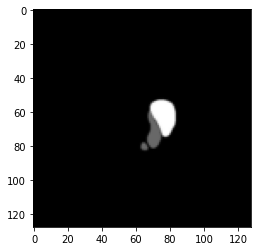

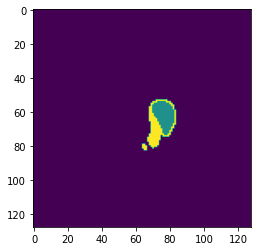

In [ ]:
#getting a sample image and mask from an arbitrary patient and displaying it.
# target_map is the semantically segmented ground truth to be used in loss func
train_sampleimage,train_samplemask,imagePath,maskPath,target_map=train_dataset.__getitem__(670)

print("Sample image shape: ",train_sampleimage.shape)
# image_np= np.asarray(train_sampleimage)

# print(image_np.size)
print("Target map shape: ",target_map.shape)
print("Number of pixels in target map: ",target_map.size)


print("Length of sample dataset: ",train_dataset.__len__())
# visualiser_sample(train_sampleimage)
# visualiser_sample(train_samplemask)

pyplot.imshow(train_samplemask.permute(1,2,0))
pyplot.show()

#for pyplot to show image, it must be in format: width,height. target map-> channel, width, height
pyplot.imshow(np.squeeze(target_map)) #squeeze removes the channel dimension as its just 1

pyplot.show()

# **Creation of DataLoaders for the training dataset**

In [ ]:
#making dataloaders for the train, test and val sets.

train_loader= DataLoader(train_dataset,batch_size=16,shuffle=False,drop_last=True)

shuffled_train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True,drop_last=True)

# print(sample_dataset.__len__())

image,mask,imagePath,maskPath,target_mask= next(iter(shuffled_train_loader))   

print("Image path: ",imagePath)
print("Mask path: ",maskPath)

#sample_loader=DataLoader(sample_dataset,batch_size=16,shuffle=False)



Image path:  ('/content/Prepared_Dataset/train/images/patient9-slice182.jpg', '/content/Prepared_Dataset/train/images/patient44-slice031.jpg', '/content/Prepared_Dataset/train/images/patient22-slice054.jpg', '/content/Prepared_Dataset/train/images/patient97-slice228.jpg', '/content/Prepared_Dataset/train/images/patient25-slice125.jpg', '/content/Prepared_Dataset/train/images/patient34-slice209.jpg', '/content/Prepared_Dataset/train/images/patient85-slice277.jpg', '/content/Prepared_Dataset/train/images/patient18-slice194.jpg', '/content/Prepared_Dataset/train/images/patient18-slice512.jpg', '/content/Prepared_Dataset/train/images/patient95-slice023.jpg', '/content/Prepared_Dataset/train/images/patient65-slice212.jpg', '/content/Prepared_Dataset/train/images/patient7-slice133.jpg', '/content/Prepared_Dataset/train/images/patient82-slice150.jpg', '/content/Prepared_Dataset/train/images/patient28-slice077.jpg', '/content/Prepared_Dataset/train/images/patient98-slice337.jpg', '/content/Pre

# **Instantiating the UNET implementation model**

Encoder:
Down-sample -> Max-pooling to reduce the size of the image.
Conv2D-> To increase the number of channels.

Decoder: 
Up-Sample -> To increase the image size
Conv2D-> To decrease the number of channels

In [ ]:
#Instantiate the Block, Encoder,Decoder and UNET classes. Pass data into the UNET Class (model's data entrypoint)
print("The device being used is: ",device)

seg_map_height=128
seg_map_width=128

#encoding_channels=(3,64,128),decoding_channels=(256,128,64,2)
UNET_Model= UNet(encoding_channels=(3,64,128,256,512),decoding_channels=(1024,512,256,128,64),outSize=(seg_map_height,seg_map_width),seg_classes=3,dilation_rate=2)
UNET_Model.to(device)

print("Encoder channels: ",UNET_Model.encoder.channels)
print("Decoder Channels: ", UNET_Model.decoder.channels)

print("Model summary:")
print(UNET_Model)

# loss_func=torch.nn.BCEWithLogitsLoss()
# # train_sampleimage,train_samplemask=train_dataset.__getitem__(10)
# for (batch_index,(image,mask,imagePath,maskPath)) in enumerate(sample_loader):  
#   predictions=UNET_Model(image)
#   print("Image used: ",imagePath)
#   print("Mask used: ",maskPath)
#   print("Loss: ",loss_func(predictions,mask))

# #the torch.squeeze is done to remove the batch_size dimension from the image, which is usually 1 [batch_size,channels,height,width].

# print("The data type of the prediction is : ",type(predictions))
# predictions=torch.squeeze(predictions)
# visualiser_colab(predictions.detach().numpy())
# mask=torch.squeeze(mask)
# visualiser_colab(mask)


The device being used is:  cuda
Encoder channels:  (3, 64, 128, 256, 512)
Decoder Channels:  (1024, 512, 256, 128, 64)
Model summary:
UNet(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): Block(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

# **Implementation of the Dice Score metric and the IoU metric**

In [ ]:
def DCS_for_class(prediction_mask, true_mask, class_idx):
    eps = 1e-7
    
    #converting logits into probabilities
    pred_mask = torch.nn.functional.softmax(prediction_mask, dim=1)
    #considering only the channel that represents the class for which dice score is being calculated
    pred_mask = pred_mask[:, class_idx, :, :]
    #removing the 1 channel (class) from ground truth mask
    true_mask = true_mask.squeeze(1)

    #converting the ground truth semantically labeled mask into a one-hot encoded binary mask 
    binary_true_mask = true_mask == class_idx

    #thresholding to convert probability into class
    intersection = (pred_mask > 0.5) & binary_true_mask
    intersection = intersection.float().sum()
    union = (pred_mask > 0.5).float().sum() + binary_true_mask.float().sum()

    dice_coeff = (2. * intersection + eps) / (union + eps)
    return dice_coeff.item()

def multi_class_dice_coefficient(pred_mask, true_mask, num_classes):

    DCS_per_class=[]
    #getting the dice score for every class
    for i in range(num_classes):
        DCS_per_class.append(DCS_for_class(pred_mask, true_mask, i))
    
    #length would be num_classes, in this case 3.
    return DCS_per_class


In [ ]:
'''accuracy score functions'''
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex


def calc_IOU_for_epoch(predictions_list, target_maps_list):
#predictions_list -> list of predictions in an epoch
#target_maps_list -> list of target_maps(ground-truth) in an epoch 
#predictions of shape -> [batch_size, channels(num of classes),width,height]
#target shape -> [batch_size,height,width] [height,width]= range(0,num_classes)

  mean_IOU_per_batch=[]
  IOU_Class0_per_batch=[] 
  IOU_Class1_per_batch=[] 
  IOU_Class2_per_batch=[] 

  for i in range(len(predictions_list)):
    prediction=predictions_list[i].cpu()
    target_map=target_maps_list[i].cpu()

    IOU_func= MulticlassJaccardIndex(num_classes=3,average="none")
    IOU_per_prediction= IOU_func(prediction,target_map)

    mean_IOU_per_batch.append(sum(IOU_per_prediction)/len(IOU_per_prediction))
    IOU_Class0_per_batch.append(IOU_per_prediction[0])
    IOU_Class1_per_batch.append(IOU_per_prediction[1])
    IOU_Class2_per_batch.append(IOU_per_prediction[2])

    #print("IOU per class shape:",IOU_per_prediction.shape)

    #print("IOU Score per class for this batch of predicted maps is : ",IOU_per_prediction[0], IOU_per_prediction[1], IOU_per_prediction[2])

  
  IOU_for_epoch=[]
  
  '''average mean IOU(IOU class1+IOU class2+IOU class3/num_classes) across epoch'''
  IOU_for_epoch.append(sum(mean_IOU_per_batch)/len(mean_IOU_per_batch))
  ''' average IOU for class 0 across epoch'''
  IOU_for_epoch.append(sum(IOU_Class0_per_batch)/len(IOU_Class0_per_batch))
  ''' average IOU for class 1 across epoch'''
  IOU_for_epoch.append(sum(IOU_Class1_per_batch)/len(IOU_Class1_per_batch))
  ''' average IOU for class 2 across epoch'''
  IOU_for_epoch.append(sum(IOU_Class2_per_batch)/len(IOU_Class2_per_batch))


  return IOU_for_epoch
  #IOU_per epoch is a list:
  #[mean_IOU_across_predictions,mean_IOU_class1_across_predictions, ..classn_across_predictions]

  
def calc_Dice_for_epoch (predictions_list, target_maps_list):

  #dice_func=Dice(num_classes=3, average='none')
  mean_DCS_per_batch=[]
  DCS_Class0_per_batch=[]
  DCS_Class1_per_batch=[]
  DCS_Class2_per_batch=[]

  for i in range(len(predictions_list)):
    prediction=predictions_list[i].cpu()
    target_map=target_maps_list[i].cpu()

    DCS_per_prediction= multi_class_dice_coefficient(prediction,target_map,3)

    #average of the DCS across the 3 classes
    mean_DCS_per_batch.append(sum(DCS_per_prediction)/len(DCS_per_prediction))

    DCS_Class0_per_batch.append(DCS_per_prediction[0])
    DCS_Class1_per_batch.append(DCS_per_prediction[1])
    DCS_Class2_per_batch.append(DCS_per_prediction[2])

  
  DCS_for_epoch=[]

  '''Average DCS across 3 classes, for this epoch'''
  DCS_for_epoch.append(sum(mean_DCS_per_batch)/len(mean_DCS_per_batch))
  '''Average DCS for Class 0 (Background) for this epoch:'''
  DCS_for_epoch.append(sum(DCS_Class0_per_batch)/len(DCS_Class0_per_batch))
  '''Average DCS for Class 1 (TL) for this epoch:'''
  DCS_for_epoch.append(sum(DCS_Class1_per_batch)/len(DCS_Class1_per_batch))
  '''Average DCS for Class 2 (FL) for this epoch:'''
  DCS_for_epoch.append(sum(DCS_Class2_per_batch)/len(DCS_Class2_per_batch))


  return DCS_for_epoch




# **Defining the model's hyper-parameters:**

In [ ]:
#defining and initialising model hyper-parameters

initial_learning_rate=0.0001

#Optimizer function -> Adam
optimizer_function= torch.optim.Adam(params=UNET_Model.parameters(),lr=initial_learning_rate)

batch_size=16

num_epochs=50

training_loss_list=[]

#loss_func= binary_cross_entropy
#loss_function=torch.nn.BCEWithLogitsLoss()

#loss_func= cross_entropy (as its a 3 class pixel classification problem)

'''
for CrossEntropyLoss to work, expected mask/target should be either 
Class indices in the range [0,C) where C is the number of classes or
Probabilities for each class
'''

#What I think is happening: 
'''
Mask data does not contain classes assigned to pixels. It is simply rgb pixel values.

image and mask values have been normalized from (0 to 255) to (0,1)
so what if CrossEntropyLoss is assuming them to be probability values and as all the values are between
0 and 1 (like 0.2, 0.3, 0.5) it is flooring them to be class 0?.

'''

loss_function=torch.nn.CrossEntropyLoss()



# **Training the model on the training samples.**

Calculating loss/error using the loss function. 
Backpropagating the error through the model, to readjust weights.
Displaying the Dice score and IoU score per epoch


In [ ]:
IOU_per_epoch=[]
DCS_per_epoch=[]

#Training

#epoch -> entire run of a CNN through an entire training dataset.
#enumeration of a data loader-> passing batches of data to train the model, backpropogate error and optimise weights

for i in range(1,num_epochs+1):
  #setting the model mode to train
  UNET_Model.train()
  images_path_list=[]
  masks_path_list=[]

  images_list=[]
  masks_list=[]
  
  predictions_list=[]
  target_maps_list=[]

  #looping through batches of data made by the training DataLoader.
  for (batch_index,(image,mask,imagePath,maskPath,target_map)) in tqdm.tqdm(enumerate(shuffled_train_loader),total=len(shuffled_train_loader)):
    
    #switching the data over to the GPU
    image=image.to(device)
    #target_map (a np array) becomes a tensor . values still remain the same (0,1,2)
    #shape of target-> batch, 1(channel), width, height

    target_map= torch.squeeze(target_map) #removing the 1 channel this is because CELoss expects form->[N, H, W]
    target_map=target_map.to(dtype=torch.long)
    target_map=target_map.to(device) 

    
    #adding images and masks in this list to batch
    images_list.append(image)
    masks_list.append(mask)
    target_maps_list.append(target_map)
    images_path_list.append(imagePath)
    masks_path_list.append(maskPath)

    #making the prediction for the input image
    predictions=UNET_Model(image)
    
    # moving predictions to cpu and appending it to list, to prevent CUDA running out of memory.
    predictions_list.append(predictions.cpu())

    #predictions_list.append(predictions)

    #Calculating loss
    
    loss=loss_function(predictions,target_map)
    training_loss_list.append(loss.item())

    #zeroing out accumulated gradients as weights have already been modified according to them during the previous run.
    optimizer_function.zero_grad()

    #Back propogation:
    loss.backward()

    #updating weights
    optimizer_function.step()

    
  
  '''calculate IOU per epoch'''
  #end of epoch loop
  IOU_per_epoch.append(calc_IOU_for_epoch(predictions_list,target_maps_list))
  print(f"----------------------After epoch {i}------------------------------------------")
  print(IOU_per_epoch)
  print(f"At end of epoch {i}, the mean IOU across 3 classes is: ",IOU_per_epoch[i-1][0])
  print(f"At end of epoch {i}, the mean IOU for class 0(Background) is: ",IOU_per_epoch[i-1][1] )
  print(f"At end of epoch {i}, the mean IOU for class 1(TL) is: ",IOU_per_epoch[i-1][2] )
  print(f"At end of epoch {i}, the mean IOU for class 2(FL) is: ",IOU_per_epoch[i-1][3] )

  '''calculate Dice Score per epoch'''
  DCS_per_epoch.append(calc_Dice_for_epoch(predictions_list,target_maps_list))
  
  print("\n")
  print(DCS_per_epoch)
  print(f"At end of epoch {i}, the mean DCS across 3 classes is: ",DCS_per_epoch[i-1][0])
  print(f"At end of epoch {i}, the mean DCS for class 0(Background) is: ",DCS_per_epoch[i-1][1] )
  print(f"At end of epoch {i}, the mean DCS for class 1(TL) is: ",DCS_per_epoch[i-1][2] )
  print(f"At end of epoch {i}, the mean DCS for class 2(FL) is: ",DCS_per_epoch[i-1][3] )

  #saving the model every 5 epochs.
  if(i%5==0):
    #SAVING THE MODEL
    print("Saving the model at epoch: ",i)
    save_path="/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Full_dataset_saved_models/Atrous_Models/round2_atrous_model-Seed7-{}epochs"
    path=save_path.format(i)
    torch.save(UNET_Model,path)

print("Ended training phase")
print("Training losses are as follows: ",training_loss_list)

##NOTE: Images are represented during training in the format: [batchsize,channels,height,width]

#displaying the predicted mask and the actual mask
print("The data type of the prediction is : ",type(predictions))



100%|██████████| 1490/1490 [09:38<00:00,  2.58it/s]


----------------------After epoch 1------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)]]
At end of epoch 1, the mean IOU across 3 classes is:  tensor(0.4601)
At end of epoch 1, the mean IOU for class 0(Background) is:  tensor(0.9925)
At end of epoch 1, the mean IOU for class 1(TL) is:  tensor(0.0032)
At end of epoch 1, the mean IOU for class 2(FL) is:  tensor(0.3845)


[[0.4653959355236353, 0.9839854130408908, 5.0488665398238945e-05, 0.41215190486461667]]
At end of epoch 1, the mean DCS across 3 classes is:  0.4653959355236353
At end of epoch 1, the mean DCS for class 0(Background) is:  0.9839854130408908
At end of epoch 1, the mean DCS for class 1(TL) is:  5.0488665398238945e-05
At end of epoch 1, the mean DCS for class 2(FL) is:  0.41215190486461667


100%|██████████| 1490/1490 [09:38<00:00,  2.57it/s]


----------------------After epoch 2------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)]]
At end of epoch 2, the mean IOU across 3 classes is:  tensor(0.7145)
At end of epoch 2, the mean IOU for class 0(Background) is:  tensor(0.9987)
At end of epoch 2, the mean IOU for class 1(TL) is:  tensor(0.4377)
At end of epoch 2, the mean IOU for class 2(FL) is:  tensor(0.7070)


[[0.4653959355236353, 0.9839854130408908, 5.0488665398238945e-05, 0.41215190486461667], [0.790157171250552, 0.9993734400544391, 0.5486454158824215, 0.8224526578147939]]
At end of epoch 2, the mean DCS across 3 classes is:  0.790157171250552
At end of epoch 2, the mean DCS for class 0(Background) is:  0.9993734400544391
At end of epoch 2, the mean DCS for class 1(TL) is:  0.5486454158824215
At end of epoch 2, the mean DCS for class 2(FL) is:  0.8224526578147939


100%|██████████| 1490/1490 [09:38<00:00,  2.57it/s]


----------------------After epoch 3------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)]]
At end of epoch 3, the mean IOU across 3 classes is:  tensor(0.8371)
At end of epoch 3, the mean IOU for class 0(Background) is:  tensor(0.9992)
At end of epoch 3, the mean IOU for class 1(TL) is:  tensor(0.6996)
At end of epoch 3, the mean IOU for class 2(FL) is:  tensor(0.8123)


[[0.4653959355236353, 0.9839854130408908, 5.0488665398238945e-05, 0.41215190486461667], [0.790157171250552, 0.9993734400544391, 0.5486454158824215, 0.8224526578147939], [0.9046360661852799, 0.9996106612202306, 0.8188551359328647, 0.8954424014027487]]
At end of epoch 3, the mean DCS across 3 classes is:  0.9046360661852799
At end of epoch 3, the mean DCS for class 0(Background) is:  0.9996106612202306
At end of epoch 3, the mean DCS for 

100%|██████████| 1490/1490 [09:38<00:00,  2.57it/s]


----------------------After epoch 4------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)]]
At end of epoch 4, the mean IOU across 3 classes is:  tensor(0.8835)
At end of epoch 4, the mean IOU for class 0(Background) is:  tensor(0.9994)
At end of epoch 4, the mean IOU for class 1(TL) is:  tensor(0.7901)
At end of epoch 4, the mean IOU for class 2(FL) is:  tensor(0.8610)


[[0.4653959355236353, 0.9839854130408908, 5.0488665398238945e-05, 0.41215190486461667], [0.790157171250552, 0.9993734400544391, 0.5486454158824215, 0.8224526578147939], [0.9046360661852799, 0.9996106612202306, 0.8188551359328647, 0.8954424014027487], [0.9351347360168262, 0.9997134919534594, 0.880738980178065, 0.924951735918954]]
At end of epoch 4, the mean DCS across 3 cl

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 5------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)]]
At end of epoch 5, the mean IOU across 3 classes is:  tensor(0.9031)
At end of epoch 5, the mean IOU for class 0(Background) is:  tensor(0.9995)
At end of epoch 5, the mean IOU for class 1(TL) is:  tensor(0.8267)
At end of epoch 5, the mean IOU for class 2(FL) is:  tensor(0.8829)


[[0.4653959355236353, 0.9839854130408908, 5.0488665398238945e-05, 0.41215190486461667], [0.790157171250552, 0.9993734400544391, 0.5486454158824215, 0.8224526578147939], [0.9046360661852799, 0.9996106612202306, 0.8188551359328647, 0.8954424014027487], [0.9351347360168262, 0.9997134919534594, 0.88073898017806

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 6------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)]]
At end of epoch 6, the mean IOU across 3 classes is:  tensor(0.9172)
At end of epoch 6, the mean IOU for class 0(Background) is:  tensor(0.9996)
At end of epoch 6, the mean IOU for class 1(TL) is:  tensor(0.8530)
At end of epoch 6, the mean IOU for class 2(FL) is:  tensor(0.8991)


[[0.4653959355236353, 0.9839854130408908, 5.0488665398238945e-05, 0.41215190486461667], [0.790157171250552, 0.9993734400544391, 0.5486454158824215, 0.8224526578147939], [0.9046360661852799, 0.9996106612202306, 0.8188551359328647, 0.8954424014

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 7------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)]]
At end of epoch 7, the mean IOU across 3 classes is:  tensor(0.9269)
At end of epoch 7, the mean IOU for class 0(Background) is:  tensor(0.9996)
At end of epoch 7, the mean IOU for class 1(TL) is:  tensor(0.8705)
At end of epoch 7, the mean IOU for class 2(FL) is:  tensor(0.9105)


[[0.4653959355236353, 0.9839854130408908, 5.0488665398238945e-05, 0.41215190486461667], [0.790157171250552, 0.9993734400544391, 0.5486454158824215, 0.8224526578147939], [0.9046

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 8------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)]]
At end of epoch 8, the mean IOU across 3 classes is:  tensor(0.9330)
At end of epoch 8, the mean IOU for class 0(Background) is:  tensor(0.9997)
At end of epoch 8, the mean IOU for class 1(TL) is:  tensor(0.8823)
At end of epoch 8, the mean IOU for class 2(FL) is:  tensor(0.9170)


[[0.4653959355236353, 0.9839854130408908, 5.0488665398238945e-05, 0.41215190486461667], [0.790157171250552, 0.

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 9------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)]]
At end of epoch 9, the mean IOU across 3 classes is:  tensor(0.9403)
At end of epoch 9, the mean IOU for class 0(Background) is:  tensor(0.9997)
At end of epoch 9, the mean IOU for class 1(TL) is:  tensor(0.8953)
At end of epoch 9, the mean IOU for class 2(FL) is:  tensor(0.9259)


[[0.4653959355236353, 0.9839854130408908, 5.

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 10------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)]]
At end of epoch 10, the mean IOU across 3 classes is:  tensor(0.9431)
At end of epoch 10, the mean IOU for class 0(Background) is:  tensor(0.9997)
At end of epoch 10, the mean IOU for class 1(TL) is:  tensor(0.8998)
At end of epoch 10, the mean IOU for class 2

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 11------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)]]
At end of epoch 11, the mean IOU across 3 classes is:  tensor(0.9484)
At end of epoch 11, the mean IOU for class 0(Background) is:  tensor(0.9997)
At end of epoch 11, the mean IOU for class 1(TL

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 12------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)]]
At end of epoch 12, the mean IOU across 3 classes is:  tensor(0.9508)
At end of epoch 12, the mean IOU for class 0(Background) i

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 13------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)]]
At end of epoch 13, the mean IOU across 3 classes is:  tensor(

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 14------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 15------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 16------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 17------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 18------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 19------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 20------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 21------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 22------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 23------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 24------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 25------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 26------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 27------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 28------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 29------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 30------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 31------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 32------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 33------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 34------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:41<00:00,  2.56it/s]


----------------------After epoch 35------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 36------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 37------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 38------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 39------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 40------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 41------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 42------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.56it/s]


----------------------After epoch 43------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 44------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 45------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 46------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:43<00:00,  2.55it/s]


----------------------After epoch 47------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 48------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 49------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

100%|██████████| 1490/1490 [09:42<00:00,  2.56it/s]


----------------------After epoch 50------------------------------------------
[[tensor(0.4601), tensor(0.9925), tensor(0.0032), tensor(0.3845)], [tensor(0.7145), tensor(0.9987), tensor(0.4377), tensor(0.7070)], [tensor(0.8371), tensor(0.9992), tensor(0.6996), tensor(0.8123)], [tensor(0.8835), tensor(0.9994), tensor(0.7901), tensor(0.8610)], [tensor(0.9031), tensor(0.9995), tensor(0.8267), tensor(0.8829)], [tensor(0.9172), tensor(0.9996), tensor(0.8530), tensor(0.8991)], [tensor(0.9269), tensor(0.9996), tensor(0.8705), tensor(0.9105)], [tensor(0.9330), tensor(0.9997), tensor(0.8823), tensor(0.9170)], [tensor(0.9403), tensor(0.9997), tensor(0.8953), tensor(0.9259)], [tensor(0.9431), tensor(0.9997), tensor(0.8998), tensor(0.9299)], [tensor(0.9484), tensor(0.9997), tensor(0.9096), tensor(0.9358)], [tensor(0.9508), tensor(0.9998), tensor(0.9134), tensor(0.9393)], [tensor(0.9527), tensor(0.9998), tensor(0.9168), tensor(0.9416)], [tensor(0.9545), tensor(0.9998), tensor(0.9199), tensor(0.9439

# **Visualising some of the predictions made during training.**

Predictions stored:  1490
Predictions(from model) shape: torch.Size([16, 3, 128, 128])
Images stored 1490
Masks stored 1490
Target maps stored 1490
Shape of the Image from list :  torch.Size([16, 3, 128, 128])
Shape of the expected mask from list:  torch.Size([16, 3, 128, 128])
Shape of the predictions from list:  torch.Size([16, 3, 128, 128])
Shape of the target_maps from list:  torch.Size([16, 128, 128])
Input image


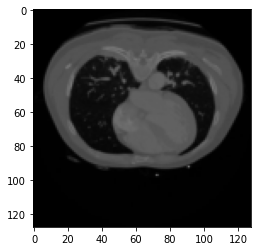

Expected mask


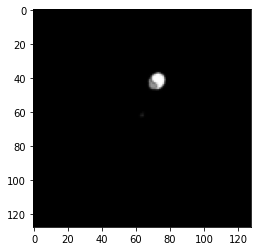

Ground truth target mask passed into loss func:
<class 'torch.Tensor'>
Image shape in visualiser_colab: torch.Size([128, 128])
Image is in a tensor format


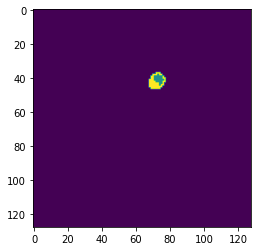

The Model output mask
Prediction type from list :  <class 'torch.Tensor'>
predictions shape before being displayed:  torch.Size([3, 128, 128])
Predictions shape after permuting it: torch.Size([128, 128, 3])
<class 'numpy.ndarray'>
Image shape in visualiser_colab: (128, 128, 3)
Image is a numpy array


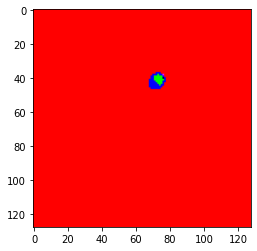

Predictions values tensor([-42.1115, -41.7785, -38.8201,  ...,  24.7560,  25.5879,  26.5742],
       grad_fn=<Unique2Backward0>)
Target_map unique values:  tensor([0, 1, 2])


In [ ]:
#array[0][:][:][:]
#print("Image paths stored",len(images_path_list))
#print("Mask paths stored",len(masks_path_list))

print("Predictions stored: ",len(predictions_list))
print("Predictions(from model) shape:",predictions.shape)

print("Images stored",len(images_list))
print("Masks stored",len(masks_list))
print("Target maps stored", len(target_maps_list))

#getting a certain index of predictions,images and masks.
list_index=230
image=images_list[list_index]
mask= masks_list[list_index]
predictions=predictions_list[list_index]
target_map=target_maps_list[list_index]

#to convert tensor to numpy array to plot, switch it from gpu to cpu
mask=mask.cpu()
predictions=predictions.cpu()
image=image.cpu()
target_map=target_map.cpu()

print("Shape of the Image from list : ", image.shape)
print("Shape of the expected mask from list: ", mask.shape)
print("Shape of the predictions from list: ", predictions.shape)
print("Shape of the target_maps from list: ",target_map.shape)
# print("Image used: ",images_path_list[list_index])
# print("Mask used: ",masks_path_list[list_index])


batch=batch_size-1

#taking a single image from the batch of images, 
#permuting it to display it and then displaying the input image using pyplot's imshow function.
print("Input image")
image=image[batch][:][:][:]
image=image.permute(1,2,0)
plt.imshow(image.detach().numpy())
plt.show()

#reading in mask 1, from the batch of 32. 
#Also permuting it, so shape becomes [height,width,channel]
print("Expected mask")
mask=mask[batch][:][:][:]
mask=mask.permute(1,2,0)
plt.imshow(mask.detach().numpy())
plt.show()


print("Ground truth target mask passed into loss func:")
individual_target_map=target_map[batch][:][:]
visualiser_colab(individual_target_map)
print("The Model output mask")

print("Prediction type from list : ",type(predictions))

#reading in prediction 1, from the batch of 32
#also permuting it so shape becomes [height,width,channel]
individual_prediction=predictions[batch][:][:][:]
print("predictions shape before being displayed: ",individual_prediction.shape)
individual_prediction=individual_prediction.permute(1,2,0) #shape becomes 128,128,3
print("Predictions shape after permuting it:",individual_prediction.shape)
# predictions=transf(predictions)
visualiser_colab(individual_prediction.detach().numpy())


print("Predictions values", torch.unique(individual_prediction))

print("Target_map unique values: ",torch.unique(individual_target_map))


In [ ]:
#SAVING THE MODEL
path="/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/atrous_model_3epochs"
torch.save(UNET_Model,path)

# **Validating the model by loading it and testing it on unseen data.**

In [ ]:
#model=torch.load("/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Full_dataset_saved_models/shuffled_trained_models/shuffled_trained_model-fulldataset_Seed7-50epochs")
model=torch.load("/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Full_dataset_saved_models/Atrous_Models/round2_atrous_model-Seed7-50epochs")
model.eval()

UNet(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): Block(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=Fals

# Creation of the **Validation Dataset** and the Validation **DataLoader** 

In [ ]:
#creating the validation and testing datasets.
val_path="/content/Prepared_Dataset/val"

#specifying transforms-> resizing the image and converting it to a Tensor
val_transforms=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])

#creating the validation dataset and dataloader.
val_dataset= CTADataset(os.path.join(val_path,"images"),os.path.join(val_path,"masks"),transform=val_transforms)





Creating semantically labelled segmentation maps


In [ ]:
val_loader= DataLoader(val_dataset,batch_size=16,shuffle=True,drop_last=True)
#loading in "trained" model
print("Length of val loader: ",len(val_loader))
print("Length of val dataset: ",len(val_dataset))


Length of val loader:  331
Length of val dataset:  5300


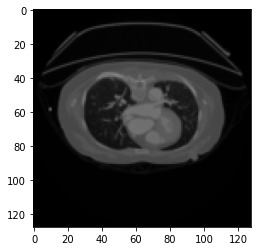

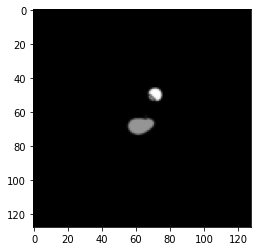

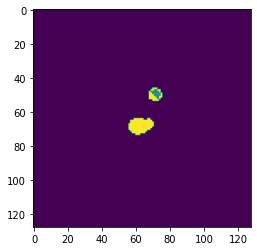

val image shape after adding channel dimension torch.Size([1, 3, 128, 128])
prediction shape torch.Size([1, 3, 128, 128])

Dice Score [background, tl,fl ]:  [0.9995684623718262, 0.7333333492279053, 0.9251700639724731]


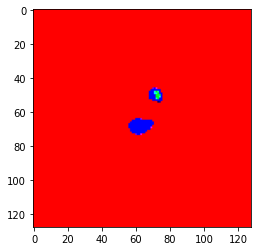

In [ ]:


val_image, val_mask,img_path,mask_path,val_target_map=val_dataset.__getitem__(530)

plt.imshow(val_image.permute(1,2,0))
plt.show()

plt.imshow(val_mask.permute(1,2,0))
plt.show()

plt.imshow(np.squeeze(val_target_map))
plt.show()

resizer= torchvision.transforms.Resize(size=(128,128))
val_image=resizer(val_image)
val_image = val_image[None,:, :]
print("val image shape after adding channel dimension", val_image.shape)

#prediction being made
val_image=val_image.to(device)
val_prediction=model(val_image)
val_prediction=val_prediction.cpu()
print("prediction shape",val_prediction.shape)

Dice=multi_class_dice_coefficient(val_prediction, torch.from_numpy(val_target_map), 3)
print("\nDice Score [background, tl,fl ]: ", Dice)

val_prediction=torch.squeeze(val_prediction)
val_prediction=val_prediction.permute(1,2,0)
plt.imshow(val_prediction.detach().numpy())
plt.show()




# **Evaluation of the model on the validation set**

In [ ]:
# testing model on validation set:
images_list=[]
masks_list=[]
image_path_list=[]
mask_path_list=[]
predictions_list=[]
target_maps_list=[]

with torch.no_grad():
  for (batch_index,(image,mask,imagePath,maskPath,target_map)) in tqdm.tqdm(enumerate(val_loader),total=len(val_loader)):
      
      #switching the data over to the GPU
      image=image.to(device)
      #somehow target_map becomes a tensor from a np array. values still remain the same (0,1,2)
      #shape of target-> batch, 1(channel), width, height

      target_map= torch.squeeze(target_map) #removing the 1 channel this is because CELoss expects form->[N, H, W]
      #print("target_map dimension",target_map.shape)
      target_map=target_map.to(dtype=torch.long)
      target_map=target_map.to(device) 

    
      #adding images and masks in this list to batch
      images_list.append(image)
      masks_list.append(mask)
      image_path_list.append(imagePath)
      mask_path_list.append(maskPath)
      
      target_maps_list.append(target_map)

      predictions=model(image)
      predictions_list.append(predictions)

  

    


IOU_per_epoch=calc_IOU_for_epoch(predictions_list,target_maps_list)
print(IOU_per_epoch)
print(f"----------------------After end of validation------------------------------------------")
print(f"The mean IOU across 3 classes is: ",IOU_per_epoch[0])
print(f"The mean IOU for class 0(Background) is: ",IOU_per_epoch[1] )
print(f"The mean IOU for class 1(TL) is: ",IOU_per_epoch[2] )
print(f"The mean IOU for class 2(FL) is: ",IOU_per_epoch[3] )

'''calculate Dice Score per epoch'''
DCS_per_epoch=calc_Dice_for_epoch(predictions_list,target_maps_list)

print(DCS_per_epoch)
print("\n")
print(f"The mean DCS across 3 classes is: ",DCS_per_epoch[0])
print(f"The mean DCS for class 0(Background) is: ",DCS_per_epoch[1] )
print(f"The mean DCS for class 1(TL) is: ",DCS_per_epoch[2] )
print(f"The mean DCS for class 2(FL) is: ",DCS_per_epoch[3] )


100%|██████████| 331/331 [01:01<00:00,  5.36it/s]


[tensor(0.6837), tensor(0.9987), tensor(0.3849), tensor(0.6674)]
----------------------After end of validation------------------------------------------
The mean IOU across 3 classes is:  tensor(0.6837)
The mean IOU for class 0(Background) is:  tensor(0.9987)
The mean IOU for class 1(TL) is:  tensor(0.3849)
The mean IOU for class 2(FL) is:  tensor(0.6674)
[0.7815798801507833, 0.9993705837748202, 0.5465146552129815, 0.7988544014645487]


The mean DCS across 3 classes is:  0.7815798801507833
The mean DCS for class 0(Background) is:  0.9993705837748202
The mean DCS for class 1(TL) is:  0.5465146552129815
The mean DCS for class 2(FL) is:  0.7988544014645487


# **Visualising some of the predictions made**, along with input images.

Input image


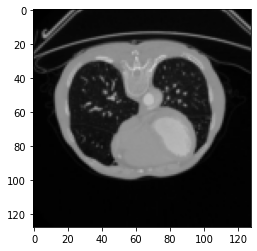

Expected mask


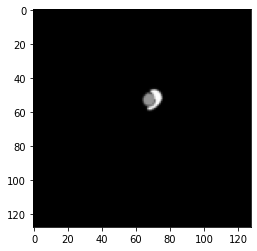

Ground truth target mask passed into loss func:
<class 'torch.Tensor'>
Image shape in visualiser_colab: torch.Size([128, 128])
Image is in a tensor format


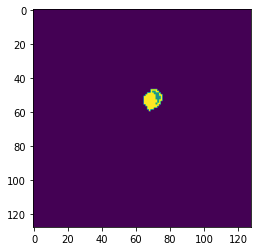

The Model output mask
predictions shape before being displayed:  torch.Size([3, 128, 128])
Predictions shape after permuting it: torch.Size([128, 128, 3])
<class 'numpy.ndarray'>
Image shape in visualiser_colab: (128, 128, 3)
Image is a numpy array


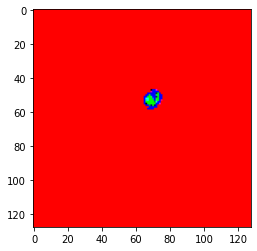

In [ ]:
#displaying images,masks, labelled masks and predictions from val set
list_index=180
image=images_list[list_index]

#getting a certain index of predictions,images and masks.
image=images_list[list_index]
mask= masks_list[list_index]
predictions=predictions_list[list_index]
target_map=target_maps_list[list_index]

#to convert tensor to numpy array to plot, switch it from gpu to cpu
mask=mask.cpu()
predictions=predictions.cpu()
image=image.cpu()
target_map=target_map.cpu()

batch=batch_size-1

#taking a single image from the batch of images, 
#permuting it to display it and then displaying the input image using pyplot's imshow function.
print("Input image")
image=image[batch][:][:][:]
image=image.permute(1,2,0)
plt.imshow(image.detach().numpy())
plt.show()

#reading in mask 1, from the batch of 32. 
#Also permuting it, so shape becomes [height,width,channel]
print("Expected mask")
mask=mask[batch][:][:][:]
mask=mask.permute(1,2,0)
plt.imshow(mask.detach().numpy())
plt.show()


print("Ground truth target mask passed into loss func:")
individual_target_map=target_map[batch][:][:]
visualiser_colab(individual_target_map)
print("The Model output mask")

#reading in prediction 1, from the batch of 32
#also permuting it so shape becomes [height,width,channel]
individual_prediction=predictions[batch][:][:][:]
print("predictions shape before being displayed: ",individual_prediction.shape)
individual_prediction=individual_prediction.permute(1,2,0) #shape becomes 128,128,3
print("Predictions shape after permuting it:",individual_prediction.shape)
# predictions=transf(predictions)
visualiser_colab(individual_prediction.detach().numpy())

In [ ]:
print("Mask path list length:",len(mask_path_list))

print("An Image path: ", image_path_list[200][12])
print("A Mask path: ", mask_path_list[200][12])



Mask path list length: 331
An Image path:  /content/Prepared_Dataset/val/images/patient43-slice268.jpg
A Mask path:  /content/Prepared_Dataset/val/masks/patient43-mask-slice268.jpg


# **Evaluating the model on the testing set:**

In [ ]:
test_path="/content/Prepared_Dataset/test"

test_transforms=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])

test_dataset=CTADataset(os.path.join(test_path,"images"),os.path.join(test_path,"masks"),transform=test_transforms)

test_loader= DataLoader(test_dataset,batch_size=16,shuffle=True,drop_last=True)
print("Length of test dataloader: ",len(test_loader))
print("Length of test dataset: ",len(test_dataset))

Creating semantically labelled segmentation maps
Length of test dataloader:  327
Length of test dataset:  5236


# **Visualising some of the predictions made**, along with input images.

In [ ]:
images_list=[]
masks_list=[]
image_path_list=[]
mask_path_list=[]
target_maps_list=[]
predictions_list=[]

with torch.no_grad():

  for (batch_index,(image,mask,imagePath,maskPath,target_map)) in tqdm.tqdm(enumerate(test_loader),total=len(test_loader)):

      #switching the data over to the GPU
      image=image.to(device)
      #somehow target_map becomes a tensor from a np array. values still remain the same (0,1,2)
      #shape of target-> batch, 1(channel), width, height

      target_map= torch.squeeze(target_map) #removing the 1 channel this is because CELoss expects form->[N, H, W]
      #print("target_map dimension",target_map.shape)
      target_map=target_map.to(dtype=torch.long)
      target_map=target_map.to(device) 

    
      #adding images and masks in this list to batch
      images_list.append(image)
      masks_list.append(mask)
      image_path_list.append(imagePath)
      mask_path_list.append(maskPath)
      
      target_maps_list.append(target_map)

      predictions=model(image)
      predictions_list.append(predictions)

  

    


IOU_per_epoch=calc_IOU_for_epoch(predictions_list,target_maps_list)
print(IOU_per_epoch)
print(f"----------------------After end of testing------------------------------------------")
print(f"The mean IOU across 3 classes is: ",IOU_per_epoch[0])
print(f"The mean IOU for class 0(Background) is: ",IOU_per_epoch[1] )
print(f"The mean IOU for class 1(TL) is: ",IOU_per_epoch[2] )
print(f"The mean IOU for class 2(FL) is: ",IOU_per_epoch[3] )

'''calculate Dice Score per epoch'''
DCS_per_epoch=calc_Dice_for_epoch(predictions_list,target_maps_list)

print(DCS_per_epoch)
print("\n")
print(f"The mean DCS across 3 classes is: ",DCS_per_epoch[0])
print(f"The mean DCS for class 0(Background) is: ",DCS_per_epoch[1] )
print(f"The mean DCS for class 1(TL) is: ",DCS_per_epoch[2] )
print(f"The mean DCS for class 2(FL) is: ",DCS_per_epoch[3] )


100%|██████████| 327/327 [01:01<00:00,  5.28it/s]


[tensor(0.6932), tensor(0.9986), tensor(0.4118), tensor(0.6692)]
----------------------After end of testing------------------------------------------
The mean IOU across 3 classes is:  tensor(0.6932)
The mean IOU for class 0(Background) is:  tensor(0.9986)
The mean IOU for class 1(TL) is:  tensor(0.4118)
The mean IOU for class 2(FL) is:  tensor(0.6692)
[0.7904505379854957, 0.9992848492543632, 0.5714981248345944, 0.8005686398675318]


The mean DCS across 3 classes is:  0.7904505379854957
The mean DCS for class 0(Background) is:  0.9992848492543632
The mean DCS for class 1(TL) is:  0.5714981248345944
The mean DCS for class 2(FL) is:  0.8005686398675318
